# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

In [2]:
#%pip install altair

In [3]:
import pandas as pd
import numpy as np
from math import sqrt
import time

from sklearn.model_selection import train_test_split

#%pip install altair
import altair as alt # https://altair-viz.github.io/index.html
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing

from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

In [4]:
pd.__version__

'1.1.3'

In [5]:
random_value = 2021

### Функции

In [6]:
def alt_value_counts(df:pd.DataFrame, col:str, title:str):
    """
    Функция для отображения уникальных значений столбца и общего количества значений по каждому уникальному значению
    df - DataFrame. Данные для анализа
    col - наименование колонки, информацию о которой необходимо отобразить.
    title - Заголовок графика
    """
    series_info = df.fillna('unknown_value').groupby(col)[col].count()
    data_info = pd.DataFrame({col:series_info.index, 'Количество':series_info.values})
    
    bars = alt.Chart(data_info, title = title).mark_bar().encode(
        x='Количество:Q',
        y=col + ":O"
    )

    text = bars.mark_text(
        align='left',
        baseline='middle',
        dx=3  # Nudges text to right so it doesn't appear on top of the bar
    ).encode(
        text='Количество:Q'
    )

    return (bars + text).properties(height = len(series_info) * 20)

In [7]:
def sns_hist(series:pd.Series, title:str, ox_label:str, bins = 50):
    """
    Функция для отображения распределения исследуемой величины
    series - Исследуемый набор данных 
    title - заголовок 
    ox_label - подпись оси Ox
    """
    plt.figure(figsize=(6,4))
    sns.distplot(series)
    #sns.histplot(series, kde=True, stat = 'probability', bins=bins)
    plt.axvline(series.median())
    plt.xlabel(ox_label, fontsize=16)
    plt.ylabel('Плотность вероятности', fontsize=10)
    plt.title(title, fontsize=20)
    #rcParams['axes.titlepad'] = 0

In [8]:
def values_not_in_interval(df:pd.DataFrame, field:str, left:int, right:int):
    """
    Функция подсчитывающая количество наблюдений вне заданного интервала.
    df - DataFrame. Данные.
    field - наименование колонки, по которой проверяем интервал.
    left - левая/нижняя граница интервала
    right - правая/верхняя граница интервала
    """
    print(
        field + '. Количество наблюдений вне интервала ' + str(left) + '-' + str(right) + ' -', 
        round(df.query(field + ' < @left or '+ field + ' > @right')[field].count() / df[field].count() * 100, 2), 
        '%'
    )

In [9]:
def corr_matrix(data):
    plt.figure(figsize=(8, 8))
    sns.heatmap(data.corr(), annot=True)

<a name="paragraph0.5"></a>
#### super_split_data
Используется в [1.2.4](#paragraph1.2.4)

In [10]:
def super_split_data(data):
    # Получим обучающую и тестовую выборки 
    data_train, data_test = train_test_split(data, test_size=0.2, random_state=random_value, shuffle = True)
    
    return data_train, data_test

In [11]:
def rmse(target, predict):
    return sqrt(mean_squared_error(target, predict))

In [12]:
class Model_Quality:
    """
    Класс, обучающий модель и выводящий итоговые метрики на обучающей и тестовой выборках
    """
    def __init__(self, model, cv_params = {}):
        """
        model - Модель, которую будем изучать
        cv_params - Набор гиперпараметров, которые будем изучать
        """
        self.model = model
        self.cv_params = cv_params
    
    def find_best_params(self, X, Y):
        """
        Поиск лучших гиперпараметров с помощью кроссвалидации
        """
        self.X = X
        self.Y = Y
        #time_in = time.time()
        #self.model.fit(X, Y)
        
        self.cv = GridSearchCV(
            self.model,
            param_grid = self.cv_params,
            cv = 4,
            scoring = make_scorer(rmse, greater_is_better = False)
        )
        self.cv.fit(X, Y)
        
        #time_out = time.time()
        #self.train_time = time_out - time_in
        
    
    def fit(self, X, Y):
        """
        Функция расчета время обучения для модели с наилучшими гиперпараметрами
        """
        self.X = X
        self.Y = Y
        time_in = time.time()
        
        self.cv.best_estimator_.fit(X, Y)        # set_params(**cv.best_params_)
        
        time_out = time.time()
        self.train_time = time_out - time_in
        
    def predict(self, Xp):
        """
        Функция расчета время предсказания
        """
        time_in = time.time()
        self.Yp = self.cv.predict(Xp)
        time_out = time.time()
        self.predict_time = time_out - time_in
        return self.Yp
    
    def train_rmse(self):
        """
        Вывод rmse для обучающей выборки
        """
        return rmse(
            self.Y, 
            self.cv.predict(self.X)
        )
        
    def test_rmse(self, Y):
        """
        Вывод rmse для тестовой выборки
        """
        return rmse(
            Y, 
            self.Yp
        )
        
    def train_info(self):
        """
        Print rmse для обучающей выборки
        """
        print(
            'Обучающая выборка. rmse = ', 
            self.train_rmse()
        )
    
    def test_info(self, Y):
        """
        Print rmse для тестовой выборки
        """
        print(
            'Тестовая выборка. rmse = ', 
            self.test_rmse(Y)
        )

In [78]:
def add_result(df, model_name, time_train, time_predict, rmse_train, rmse_predict):
    #df = df.set_value(len(df), 'Модель', model_name)
    #df = df.set_value(len(df) - 1, 'Время обучения', time_train)
    #df = df.set_value(len(df) - 1, 'Время предсказания', time_predict)
    #df = df.set_value(len(df) - 1, 'RMSE. Обучающая выборка.', rmse_train)
    #df = df.set_value(len(df) - 1, 'RMSE. Тестовая выборка.', rmse_predict)
    
    df.at[len(df), 'Модель'] = model_name
    df.at[len(df) - 1, 'Время обучения'] = time_train
    df.at[len(df) - 1, 'Время предсказания'] = time_predict
    df.at[len(df) - 1, 'RMSE. Обучающая выборка.'] = rmse_train
    df.at[len(df) - 1, 'RMSE. Тестовая выборка.'] = rmse_predict
    
    
    return df

In [79]:
#ddff = get_quality_data()
#ddff.at[len(ddff), 'Модель'] = 'sad'
#ddff.at[len(ddff) - 1, 'Время обучения'] = 5.6
#ddff

In [14]:
def get_quality_data():
    return pd.DataFrame(
    columns = [
        'Модель',
        'Время обучения',
        'Время предсказания',
        'RMSE. Обучающая выборка.',
        'RMSE. Тестовая выборка.'
    ])

In [15]:
def sns_scatterplot(data, field_x, field_y, field_z, title):
    """
    График по трем переменным
    data - Данные
    field_x - наименование колонки для исследования по оси Ох
    field_y - наименование колонки для исследования по оси Оy
    field_z - наименование колонки для графического отображения на плоскости Oxy
    """
    plt.figure(figsize=(12,7))
    sns.scatterplot(
        data=data, 
        x=field_x, 
        y=field_y, 
        hue=field_z,
        legend = "full",
        size=field_z
    )
    plt.title(title, fontsize=20)
    plt.xlabel(field_x, fontsize=16)
    plt.ylabel(field_y, fontsize=16);

## Подготовка данных

Загрузим наши данные.

In [16]:
data = pd.read_csv('datasets/autos.csv')

### Изучение данных

Первые пять строк

In [17]:
display(data.head(5))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


#### Информация о колонках

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [19]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Замечаем пропуски у следующих колонок:
    
    VehicleType (316879/354369)
    Gearbox (334536/354369)
    Model (334664/354369)
    FuelType (321474/354369)
    NotRepaired (283215/354369)
    
Также отмечаем колонки, от которых можно отказаться:
    
    DateCrawled
    DateCreated
    PostalCode 
    LastSeen

#### Ознакомимся с содержимым колонок.

##### цена (евро). Price.

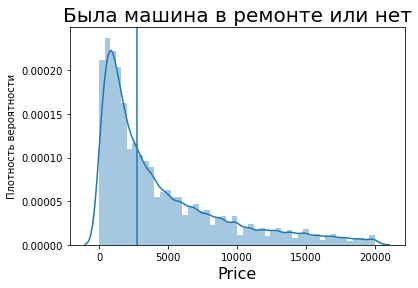

In [20]:
sns_hist(data['Price'], 'Была машина в ремонте или нет', 'Price')

Замечаем, что есть нулевые и околонулевые значения.

In [21]:
values_not_in_interval(data, 'Price', 100, 30000)

Price. Количество наблюдений вне интервала 100-30000 - 3.76 %


Установим минимальный ценник в 100 евро. Значения ниже будем отсеивать. В нашем случае это 13314 из 354369 или 3.76%. Приемлимо. 



In [22]:
data = data.query('Price >= 100')

##### Тип автомобильного кузова. VehicleType.

In [23]:
alt_value_counts(data, 'VehicleType', 'Тип автомобильного кузова')

alt.LayerChart(...)

Неизвестно 32612 значений. Это почти 10% от всей нашей выборки. Удалять не будем. Заменим пропуски на значение "unknown".

In [24]:
data['VehicleType'] = data['VehicleType'].fillna('unknown')

##### Год регистрации автомобиля. RegistrationYear.

In [25]:
alt_value_counts(data, 'RegistrationYear', 'год регистрации автомобиля')

alt.LayerChart(...)

Замечаем очень много невероятных значений - больше 2021 и меньше 1800. Нужно отсеивать.
Т.к. первый автомобиль был создан в 1886 году - установим интервал 1886-2021.

In [26]:
values_not_in_interval(data, 'RegistrationYear', 1886, 2021)

RegistrationYear. Количество наблюдений вне интервала 1886-2021 - 0.03 %


0,03% - очень мало. Спокойно избавляемся.

In [27]:
data = data.query('RegistrationYear >= 1886 and RegistrationYear <= 2021')

##### Тип коробки передач. Gearbox.

In [28]:
alt_value_counts(data, 'Gearbox', 'тип коробки передач')

alt.LayerChart(...)

16314 неизвестных значений.. Избавляться от них неохота. Заменим пропуски на значение "unknown".

In [29]:
data['Gearbox'] = data['Gearbox'].fillna('unknown')

##### Мощность (л. с.). Power.

In [30]:
alt_value_counts(data, 'Power', 'мощность (л. с.)')

alt.LayerChart(...)

Видим очень много нулей и очень много слишком больших значений. Нужно от них избавляться.
Максимальное количество л.с. по информации из интернета - 1600.
Оставим значения в разумном интервале 1-1600 л.с.

In [31]:
values_not_in_interval(
    data, 
    'Power', 
    1, 
    1600
)

Power. Количество наблюдений вне интервала 1-1600 - 10.31 %


_>11% значений.. Много, но работать с этим мусором нельзя.

In [32]:
data = data.query('Power >= 1 and Power <= 1600')

##### Модель автомобиля. Model.

In [33]:
alt_value_counts(data, 'Model', 'модель автомобиля')

alt.LayerChart(...)

Неопределенных значений 12к. Заменим пропуски на значение "unknown".

In [34]:
data['Model'] = data['Model'].fillna('unknown')

##### Пробег. Kilometer.

In [35]:
alt_value_counts(data, 'Kilometer', 'пробег')

alt.LayerChart(...)

Здесь всё хорошо.

##### Месяц регистрации автомобиля. RegistrationMonth.

In [36]:
alt_value_counts(data, 'RegistrationMonth', 'месяц регистрации автомобиля')

alt.LayerChart(...)

Значение 0 в логику не вкладывается.. Заменим его на 1. После чего данные год регистрации и месяц регистрации приведем к одной дате и рассчитаем возраст автомобиля на момент создания анкеты.

In [37]:
data['RegistrationMonth'] = data['RegistrationMonth'].replace(0, 1)

##### Тип топлива. FuelType.

In [38]:
alt_value_counts(data, 'FuelType', 'тип топлива')

alt.LayerChart(...)

Неопределенных значений 19к. Заменим пропуски на значение "unknown".

In [39]:
data['FuelType'] = data['FuelType'].fillna('unknown')

##### Марка автомобиля. Brand.

In [40]:
alt_value_counts(data, 'Brand', 'марка автомобиля')

alt.LayerChart(...)

Здесь всё ок.

##### Была машина в ремонте или нет. NotRepaired.

In [41]:
alt_value_counts(data, 'NotRepaired', 'Была машина в ремонте или нет')

alt.LayerChart(...)

71к+ неизвестных значений. Удалять столько - затея плохая. Заменим пропуски на значение "unknown".

In [42]:
data['NotRepaired'] = data['NotRepaired'].fillna('unknown')

##### Количество фотографий автомобиля. NumberOfPictures.

In [43]:
alt_value_counts(data, 'NumberOfPictures', 'количество фотографий автомобиля')

alt.LayerChart(...)

Избавимся от этого столбца.

##### Почтовый индекс владельца анкеты (пользователя). PostalCode.

In [44]:
data['PostalCode'].value_counts()

10115    800
65428    537
66333    286
60311    263
78224    259
        ... 
92549      1
7619       1
95694      1
82447      1
74937      1
Name: PostalCode, Length: 8120, dtype: int64

Избавимся и от этого столбца

#### Расчет возраста автомобиля на момент публикации

На основании года и месяца регистрации найдем дату регистрации. Отталвиваясь от этой даты и даты создания анкеты найдем возраст машины. Округлим до целых. Т.к. при покупке автомобиля пользователи, обычно, смотрят именно на целое число лет, дроби их не интересуют, поэтому ими мы можем пренебречь.

In [45]:
def gen_date(row):
    return datetime(row['RegistrationYear'], row['RegistrationMonth'], 1)

In [46]:
%%time
data['reg_date'] = data.apply(gen_date, axis = 1)

Wall time: 6.54 s


In [47]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'])

In [48]:
data['age'] = data['DateCreated'] - data['reg_date']
data['age'] = data['age']/np.timedelta64(1,'Y')

In [49]:
data['age'] = round(data['age'], 0)

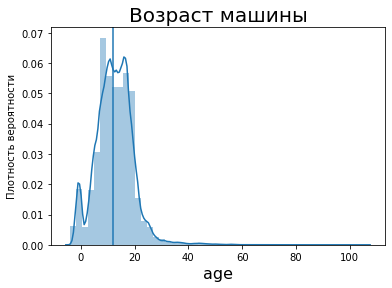

In [50]:
sns_hist(data['age'], 'Возраст машины', 'age')

Проверяем отрицательные значения возраста - дата публикации раньше даты регистрации. 

In [51]:
values_not_in_interval(data, 'age', 0, 100)

age. Количество наблюдений вне интервала 0-100 - 3.7 %


Значений много (~4%), но избавиться от них нужно

In [52]:
data = data[data['age'] >= 0]

#### Удаление столбцов

In [53]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen', 'reg_date', 'age'],
      dtype='object')

Приняли решение избавиться от следующих столбцов:

    DateCrawled
    RegistrationYear
    RegistrationMonth
    DateCreated
    NumberOfPictures
    PostalCode
    LastSeen
    reg_date

In [54]:
data = data.drop([
    'DateCrawled',
    'RegistrationYear',
    'RegistrationMonth',
    'DateCreated',
    'NumberOfPictures',
    'PostalCode',
    'LastSeen',
    'reg_date'
], axis=1)

#### матрица корреляции

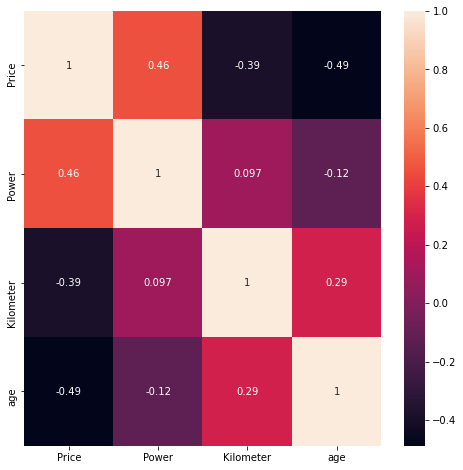

In [55]:
corr_matrix(data)

### Подготовка данных к обучению

#### Приведем наименования колонок к нижнему регистру

In [56]:
data.columns = [x.lower() for x in data.columns]

#### Кодировка категориальных признаков

Создадим один датасет воспользовавшись техникой OHE и один порядковым кодированием (для модели случайный лес). 

In [57]:
data_lr = pd.get_dummies(data, drop_first=True)


In [58]:
data_start = data.copy()

In [59]:
columns = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

In [60]:
ord_encoder = OrdinalEncoder()

data[columns] = ord_encoder.fit_transform(data[columns])

<a name="paragraph1.2.4"></a>
#### Разбиение на обучающую и тестовую выборки

[Реализация функции](#paragraph0.5)

In [61]:
data_train, data_test = super_split_data(data)
data_train_lr, data_test_lr = super_split_data(data_lr)

<a name="paragraph1.1.8"></a>
#### Разбиение на целевой признак и признаки

In [62]:
def get_target(data, target_field):
    return data[target_field]

def get_features(data, target_field):
    return data.drop([target_field], axis = 1)

In [63]:
X_train = get_features(data_train, 'price')
X_test = get_features(data_test, 'price')

Y_train = get_target(data_train, 'price')
Y_test = get_target(data_test, 'price')

In [64]:
X_train_lr = get_features(data_train_lr, 'price')
X_test_lr = get_features(data_test_lr, 'price')

Y_train_lr = get_target(data_train_lr, 'price')
Y_test_lr = get_target(data_test_lr, 'price')

In [65]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()


In [66]:
X_train_lgbm[columns] = X_train_lgbm[columns].astype('category')
X_test_lgbm[columns] = X_test_lgbm[columns].astype('category')

In [67]:
X_test_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58898 entries, 339854 to 349738
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   vehicletype  58898 non-null  category
 1   gearbox      58898 non-null  category
 2   power        58898 non-null  int64   
 3   model        58898 non-null  category
 4   kilometer    58898 non-null  int64   
 5   fueltype     58898 non-null  category
 6   brand        58898 non-null  category
 7   notrepaired  58898 non-null  category
 8   age          58898 non-null  float64 
dtypes: category(6), float64(1), int64(2)
memory usage: 2.2 MB


#### Вывод
Обнаружили пропуски в следующих колонках:

    VehicleType (316879/354369)
    Gearbox (334536/354369)
    Model (334664/354369)
    FuelType (321474/354369)
    NotRepaired (283215/354369)
    
###### Проанализировали признаки:
    
1. Цена (евро). Price. - Установили минимальный ценник в 100 евро. Значения ниже будем отсеивать. В нашем случае это 13314 из 354369 или 3.76%. Приемлимо.

2. Тип автомобильного кузова. VehicleType. - Неизвестно 32612 значений. Это почти 10% от всей нашей выборки. Удалять не будем. Заменили пропуски на значение "unknown".
    
3. Год регистрации автомобиля. RegistrationYear. - Замечаем очень много невероятных значений - больше 2021 и меньше 1800. Нужно отсеивать. Т.к. первый автомобиль был создан в 1886 году - установим интервал 1886-2021. 0,03% - очень мало. Спокойно от них избавляемся.
    
4. Тип коробки передач. Gearbox. - 16314 неизвестных значений.. Избавляться от них неохота. Заменим пропуски на значение "unknown".
    
5. Мощность (л. с.). Power. - Видим очень много нулей и очень много слишком больших значений. Нужно от них избавляться. Максимальное количество л.с. по информации из интернета - 1600. Оставим значения в разумном интервале 1-1600 л.с. >11% значений.. Много, но работать с этим мусором нельзя.
    
6. Модель автомобиля. Model. - Неопределенных значений 12к. Заменим пропуски на значение "unknown".

7. Пробег. Kilometer. - Здесь всё хорошо.

8. Месяц регистрации автомобиля. RegistrationMonth. - Значение 0 в логику не вкладывается.. Заменим его на 1. После чего данные год регистрации и месяц регистрации приведем к одной дате и рассчитаем возраст автомобиля на момент создания анкеты.
    
9. Тип топлива. FuelType. - Неопределенных значений 19к. Заменим пропуски на значение "unknown".

10. Марка автомобиля. Brand. - Здесь всё ок.

11. Была машина в ремонте или нет. NotRepaired. - 71к+ неизвестных значений. Удалять столько - затея плохая. Заменим пропуски на значение "unknown".

12. Количество фотографий автомобиля. NumberOfPictures. - Избавимся от этого столбца.

13. Почтовый индекс владельца анкеты (пользователя). PostalCode. - Избавимся и от этого столбца

######  Расчет возраста автомобиля на момент публикации

На основании года и месяца регистрации найдем дату регистрации. Отталвиваясь от этой даты и даты создания анкеты найдем возраст машины. Округлим до целых. Т.к. при покупке автомобиля пользователи, обычно, смотрят именно на целое число лет, дроби их не интересуют, поэтому ими мы можем пренебречь.
Значений много (~4%), но избавиться от них нужно.

###### Приняли решение избавиться от следующих столбцов:
    DateCrawled
    RegistrationYear
    RegistrationMonth
    DateCreated
    NumberOfPictures
    PostalCode
    LastSeen
    reg_date

###### Кодировка категориальных признаков
Создадим один датасет воспользовавшись техникой OHE и один порядковым кодированием (для модели случайный лес).

Разбили данные на обучающую и тестовую выборки.


На входе у нас было 354369 наблюдений, после предобработки осталось - 294487. Нам пришлось избавилиться от 16,9% данных.

## Обучение моделей

In [68]:
quality_info = get_quality_data()

### Линейная регрессия. На ohe-data.

In [69]:
linreg_quality = Model_Quality(LinearRegression(), {})

In [70]:
#Подбор лучших гиперпараметров:
linreg_quality.find_best_params(X_train_lr, Y_train_lr)

Обучим модель

In [71]:
linreg_quality.fit(X_train_lr, Y_train_lr)

Предскажем данные

In [72]:
linreg_quality.predict(X_test_lr)

array([ 4342.60129491,  3966.5060038 ,  6493.1641936 , ...,
       16668.53216509,  4161.85329181,   481.30199543])

Запишем результаты.

In [80]:
add_result(
    quality_info, 
    'LinearRegression. OHE.', 
    linreg_quality.train_time, 
    linreg_quality.predict_time, 
    linreg_quality.train_rmse(),
    linreg_quality.test_rmse(Y_test_lr)
)

,Модель,Время обучения,Время предсказания,RMSE. Обучающая выборка.,RMSE. Тестовая выборка.
0,LinearRegression. OHE.,6.07201,0.11,2659.03,2649.42


### Линейная регрессия. На данных с порядковым кодированием.

In [81]:
linreg_quality2 = Model_Quality(LinearRegression())

In [82]:
#Подбор лучших гиперпараметров:
linreg_quality2.find_best_params(X_train, Y_train)

Обучим модель

In [83]:
linreg_quality2.fit(X_train, Y_train)

Предскажем данные

In [84]:
linreg_quality2.predict(X_test)

array([ 3746.25439829,  4814.0495238 ,  6760.57078163, ...,
       11420.85206338,  3420.09532899,  -293.76809389])

Запишем результаты.

In [85]:
add_result(
    quality_info, 
    'LinearRegression. Ordinal encoding.', 
    linreg_quality2.train_time, 
    linreg_quality2.predict_time, 
    linreg_quality2.train_rmse(),
    linreg_quality2.test_rmse(Y_test)
)

,Модель,Время обучения,Время предсказания,RMSE. Обучающая выборка.,RMSE. Тестовая выборка.
0,LinearRegression. OHE.,6.07201,0.11,2659.03,2649.42
1,LinearRegression. Ordinal encoding.,0.0800004,0.00999999,3045.31,3043.86


### Lasso-регрессия

In [86]:
parameters = {'alpha':[0.01, 0.2, 0.4, 0.6, 0.8, 1, 1.2]}

lasso_quality = Model_Quality(linear_model.Lasso(), parameters)

In [87]:
#Подбор лучших гиперпараметров:
lasso_quality.find_best_params(X_train, Y_train)

In [88]:
lasso_quality.fit(X_train, Y_train)

In [89]:
lasso_quality.predict(X_test)

array([ 3746.29607147,  4814.05583945,  6760.57430618, ...,
       11420.79973541,  3420.09732864,  -293.73207221])

In [90]:
lasso_quality.cv.best_params_

{'alpha': 0.01}

In [91]:
add_result(
    quality_info, 
    'Lasso. Ordinal encoding. ' + str(lasso_quality.cv.best_params_), 
    lasso_quality.train_time, 
    lasso_quality.predict_time, 
    lasso_quality.train_rmse(),
    lasso_quality.test_rmse(Y_test)
)

,Модель,Время обучения,Время предсказания,RMSE. Обучающая выборка.,RMSE. Тестовая выборка.
0,LinearRegression. OHE.,6.07201,0.11,2659.03,2649.42
1,LinearRegression. Ordinal encoding.,0.0800004,0.00999999,3045.31,3043.86
2,Lasso. Ordinal encoding. {'alpha': 0.01},0.2,0.00999999,3045.31,3043.86


### Ridge-регрессия

In [92]:
parameters = {'alpha':[0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.2]}

ridge_quality = Model_Quality(Ridge(), parameters)

In [93]:
#Подбор лучших гиперпараметров:
ridge_quality.find_best_params(X_train, Y_train)

In [94]:
ridge_quality.fit(X_train, Y_train)

In [95]:
ridge_quality.predict(X_test)

array([ 3746.25608368,  4814.04968377,  6760.57098106, ...,
       11420.85038695,  3420.0952902 ,  -293.76657608])

In [96]:
add_result(
    quality_info, 
    'Ridge. Ordinal encoding.' + str(ridge_quality.cv.best_params_), 
    ridge_quality.train_time, 
    ridge_quality.predict_time, 
    ridge_quality.train_rmse(),
    ridge_quality.test_rmse(Y_test)
)

,Модель,Время обучения,Время предсказания,RMSE. Обучающая выборка.,RMSE. Тестовая выборка.
0,LinearRegression. OHE.,6.07201,0.11,2659.03,2649.42
1,LinearRegression. Ordinal encoding.,0.0800004,0.00999999,3045.31,3043.86
2,Lasso. Ordinal encoding. {'alpha': 0.01},0.2,0.00999999,3045.31,3043.86
3,Ridge. Ordinal encoding.{'alpha': 0.1},0.0540001,0.00999999,3045.31,3043.86


### Случайный лес

In [97]:
parameters = {
    'n_estimators':[20, 50],
    'min_samples_leaf':[5, 10]  
}

forest_quality = Model_Quality(RandomForestRegressor(), parameters)

In [98]:
#Подбор лучших гиперпараметров:
forest_quality.find_best_params(X_train, Y_train)

In [99]:
forest_quality.fit(X_train, Y_train)

In [100]:
forest_quality.predict(X_test)

array([ 1694.99817741,  2497.02941086,  7532.3591344 , ...,
       17407.82783474,  2560.05421127,   399.89719104])

In [101]:
add_result(
    quality_info, 
    'RandomForestRegressor. ' + str(forest_quality.cv.best_params_), 
    forest_quality.train_time, 
    forest_quality.predict_time, 
    forest_quality.train_rmse(),
    forest_quality.test_rmse(Y_test)
)

,Модель,Время обучения,Время предсказания,RMSE. Обучающая выборка.,RMSE. Тестовая выборка.
0,LinearRegression. OHE.,6.07201,0.11,2659.03,2649.42
1,LinearRegression. Ordinal encoding.,0.0800004,0.00999999,3045.31,3043.86
2,Lasso. Ordinal encoding. {'alpha': 0.01},0.2,0.00999999,3045.31,3043.86
3,Ridge. Ordinal encoding.{'alpha': 0.1},0.0540001,0.00999999,3045.31,3043.86
4,"RandomForestRegressor. {'min_samples_leaf': 5,...",36.1691,0.860001,1321.58,1579.36


In [102]:
forest_quality.cv.cv_results_

{'mean_fit_time': array([10.58776468, 25.41303569,  9.4875133 , 23.54454666]),
 'std_fit_time': array([0.64253901, 0.15403419, 0.0580409 , 0.06328903]),
 'mean_score_time': array([0.32250053, 0.76250106, 0.27250046, 0.67250091]),
 'std_score_time': array([0.01639367, 0.00433019, 0.00433012, 0.00433005]),
 'param_min_samples_leaf': masked_array(data=[5, 5, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[20, 50, 20, 50],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'min_samples_leaf': 5, 'n_estimators': 20},
  {'min_samples_leaf': 5, 'n_estimators': 50},
  {'min_samples_leaf': 10, 'n_estimators': 20},
  {'min_samples_leaf': 10, 'n_estimators': 50}],
 'split0_test_score': array([-1632.49127964, -1629.20804538, -1678.99708705, -1671.34530459]),
 'split1_test_score': array([-1622.58481077, -1613.25637371, -1661.89479695,

### DummyRegressor. Median.

In [103]:
dummy_quality = Model_Quality(
    DummyRegressor(strategy = 'median'), {}
)

In [104]:
#Подбор лучших гиперпараметров:
dummy_quality.find_best_params(X_train_lr, Y_train_lr)

In [105]:
dummy_quality.fit(X_train_lr, Y_train_lr)

In [106]:
dummy_quality.predict(X_test_lr)

array([3200., 3200., 3200., ..., 3200., 3200., 3200.])

In [107]:
add_result(
    quality_info, 
    'DummyRegressor. median.', 
    dummy_quality.train_time, 
    dummy_quality.predict_time, 
    dummy_quality.train_rmse(),
    dummy_quality.test_rmse(Y_test)
)

,Модель,Время обучения,Время предсказания,RMSE. Обучающая выборка.,RMSE. Тестовая выборка.
0,LinearRegression. OHE.,6.07201,0.11,2659.03,2649.42
1,LinearRegression. Ordinal encoding.,0.0800004,0.00999999,3045.31,3043.86
2,Lasso. Ordinal encoding. {'alpha': 0.01},0.2,0.00999999,3045.31,3043.86
3,Ridge. Ordinal encoding.{'alpha': 0.1},0.0540001,0.00999999,3045.31,3043.86
4,"RandomForestRegressor. {'min_samples_leaf': 5,...",36.1691,0.860001,1321.58,1579.36
5,DummyRegressor. median.,0,0,4912.74,4898.58


## Градиентный бустинг.

Прежде, чем приступим к исследованию градиентного бустинга - изучим его гиперпараметры по отдельности.

### Зависимость качества предсказания от количества моделей в ансамбле градиентного бустинга

In [108]:
lgbm_quality = get_quality_data()

In [109]:
trees = [2, 5, 10, 20, 50] #[1, 2, 3, 5, 10, 20, 50, 75, 100, 200]
results = []

In [110]:
%%time
for tree in trees:
    #time_in = time.time()
    
    lgbm_quality1 = Model_Quality(LGBMRegressor(n_estimators = tree), {})
    lgbm_quality1.find_best_params(X_train_lgbm, Y_train)
    #gb_model = LGBMRegressor(n_estimators = tree)
    #gb_model.fit(X_train, Y_train)
    

    #lgbm_quality1.fit(X_train_lgbm, Y_train)
    #time_out = time.time()
    #Yp = gb_model.predict(X_test)
    results.append(
        [
            tree, 
            lgbm_quality1.cv.cv_results_['mean_fit_time'][0],
            np.abs(np.abs(lgbm_quality1.cv.best_score_))
            #time_out - time_in, 
            #rmse(Yp, Y_test)
        ]
    )

Wall time: 15.4 s


In [111]:
data_rez_trees = pd.DataFrame(data=results, columns=['Кол-во моделей', 'Время обучения', 'RMSE'])

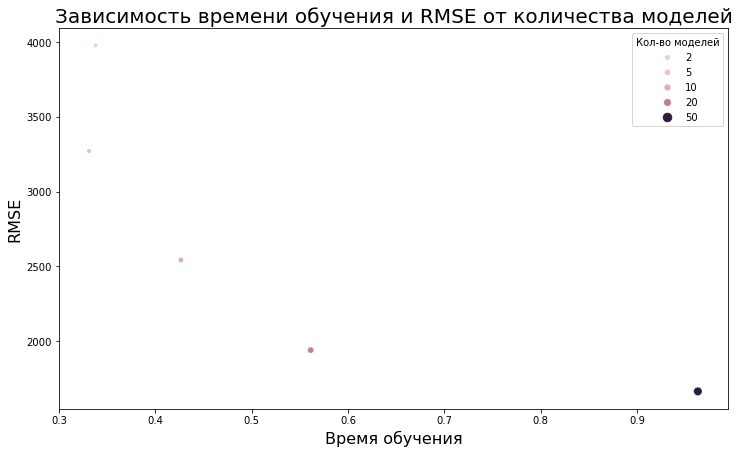

In [112]:
sns_scatterplot(
    data_rez_trees,
    'Время обучения',
    'RMSE',
    'Кол-во моделей',
    'Зависимость времени обучения и RMSE от количества моделей'
)

###### Оптимальное количество моделей в ансамбле по времени и качеству - 20/50/..

### Зависимость качества предсказания от скорости обучения

In [113]:
l_rates = [0.1, 0.3, 0.5, 0.8, 1.0, 1.5, 2]
results_lrates = []

In [114]:
%%time
for rate in l_rates:
    #time_in = time.time()
    #gb_model = LGBMRegressor(learning_rate = rate)
    #gb_model.fit(X_train, Y_train)
    #time_out = time.time()
    #Yp = gb_model.predict(X_test)
    
    lgbm_quality2 = Model_Quality(LGBMRegressor(learning_rate = rate), {})
    lgbm_quality2.find_best_params(X_train_lgbm, Y_train)
    
    results_lrates.append(
        [
            rate, 
            lgbm_quality2.cv.cv_results_['mean_fit_time'][0],
            np.abs(np.abs(lgbm_quality2.cv.best_score_))
            #time_out - time_in,
            #rmse(Yp, Y_test)
        ]
    )


Wall time: 56.1 s


In [115]:
data_rez_lrates = pd.DataFrame(data=results_lrates, columns=['Скорость обучения', 'Время обучения', 'RMSE'])

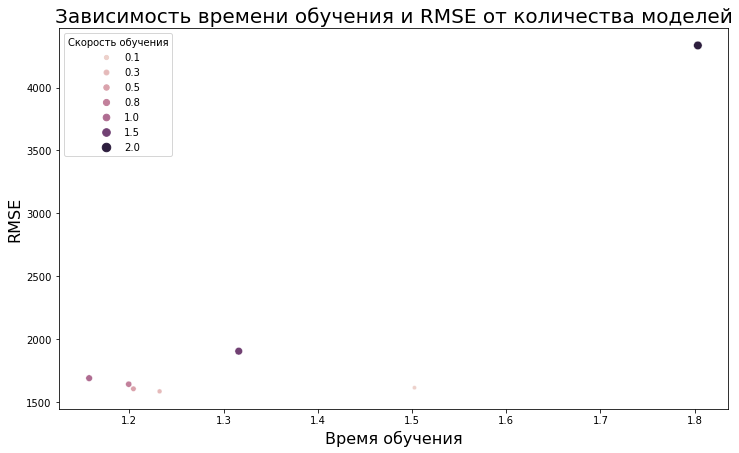

In [116]:
sns_scatterplot(
    data_rez_lrates,
    'Время обучения',
    'RMSE',
    'Скорость обучения',
    'Зависимость времени обучения и RMSE от количества моделей'
)

###### Оптимальное значение скорости обучения по времени и качеству - 0.5/0.8/1.0

### Зависимость качества предсказания от глубины дерева 

In [117]:
results_depth = []

In [118]:
%%time
for i in range(5,11):
    
    #time_in = time.time()
    #gb_model = LGBMRegressor(max_depth=i)
    #gb_model.fit(X_train, Y_train)
    #time_out = time.time()
    #Yp = gb_model.predict(X_test)
    
    lgbm_quality3 = Model_Quality(LGBMRegressor(max_depth = i), {})
    lgbm_quality3.find_best_params(X_train_lgbm, Y_train)
    
    results_depth.append(
        [
            i,
            lgbm_quality3.cv.cv_results_['mean_fit_time'][0],
            np.abs(np.abs(lgbm_quality3.cv.best_score_))
            #time_out - time_in,
            #rmse(Yp, Y_test)
        ]
    )

Wall time: 56.2 s


In [119]:
data_rez_depth = pd.DataFrame(data=results_depth, columns=['Глубина дерева', 'Время обучения', 'RMSE'])

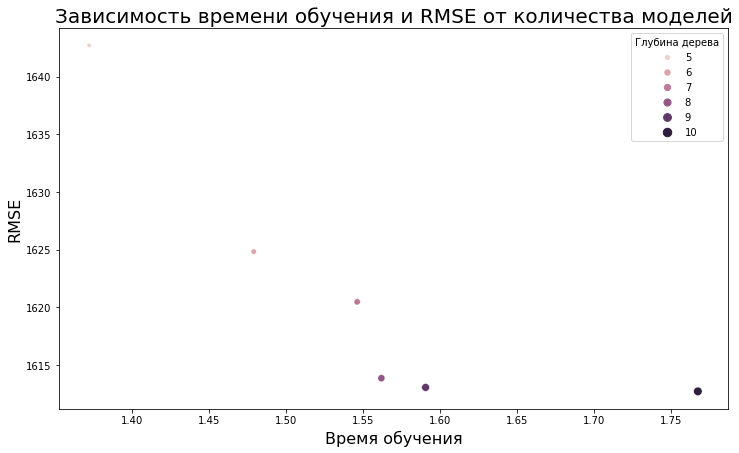

In [120]:
sns_scatterplot(
    data_rez_depth,
    'Время обучения',
    'RMSE',
    'Глубина дерева',
    'Зависимость времени обучения и RMSE от количества моделей'
)

###### Оптимальные значения - 9/10/... Но изменение глубины дерева на RMSE почти не влияет. 

### Градиентный бустинг. LGBMRegressor. Ordinal encoding.

In [121]:
parameters = {
    'n_estimators':[20, 50, 70],
    'learning_rate':[0.3, 0.5, 0.8, 1.0]  
}

lgbm_quality_oe = Model_Quality(LGBMRegressor(), parameters)

In [122]:
#Подбор лучших гиперпараметров:
lgbm_quality_oe.find_best_params(X_train, Y_train)

In [123]:
lgbm_quality_oe.fit(X_train, Y_train)

In [124]:
lgbm_quality_oe.predict(X_test)

array([ 2636.80674678,  3031.99956935,  6452.92602335, ...,
       16641.28458626,  3215.95318034,   100.5934519 ])

In [125]:
add_result(
    quality_info, 
    'LGBM. OE. ' + str(lgbm_quality_oe.cv.best_params_),
    lgbm_quality_oe.train_time, 
    lgbm_quality_oe.predict_time, 
    lgbm_quality_oe.train_rmse(),
    lgbm_quality_oe.test_rmse(Y_test)
)

,Модель,Время обучения,Время предсказания,RMSE. Обучающая выборка.,RMSE. Тестовая выборка.
0,LinearRegression. OHE.,6.07201,0.11,2659.03,2649.42
1,LinearRegression. Ordinal encoding.,0.0800004,0.00999999,3045.31,3043.86
2,Lasso. Ordinal encoding. {'alpha': 0.01},0.2,0.00999999,3045.31,3043.86
3,Ridge. Ordinal encoding.{'alpha': 0.1},0.0540001,0.00999999,3045.31,3043.86
4,"RandomForestRegressor. {'min_samples_leaf': 5,...",36.1691,0.860001,1321.58,1579.36
5,DummyRegressor. median.,0,0,4912.74,4898.58
6,"LGBM. OE. {'learning_rate': 0.5, 'n_estimators...",1.05606,0.145008,1551.04,1617.3


In [126]:
lgbm_quality_oe.cv.best_params_

{'learning_rate': 0.5, 'n_estimators': 70}

### Градиентный бустинг. LGBMRegressor. OHE.

In [127]:
parameters = {
    'n_estimators':[20, 50, 70],
    'learning_rate':[0.3, 0.5, 0.8, 1.0]  
}

lgbm_quality_ohe = Model_Quality(LGBMRegressor(), parameters)

In [128]:
%%time
#Подбор лучших гиперпараметров:
lgbm_quality_ohe.find_best_params(X_train_lr, Y_train_lr)

Wall time: 2min 26s


In [129]:
lgbm_quality_ohe.fit(X_train_lr, Y_train_lr)

In [130]:
lgbm_quality_ohe.predict(X_test_lr)

array([ 2558.8399952 ,  2572.76803125,  7281.41163718, ...,
       17432.86554063,  3589.40347972,   526.56281802])

In [131]:
add_result(
    quality_info, 
    'LGBMRegressor. OHE.' + str(lgbm_quality_ohe.cv.best_params_),
    lgbm_quality_ohe.train_time, 
    lgbm_quality_ohe.predict_time, 
    lgbm_quality_ohe.train_rmse(),
    lgbm_quality_ohe.test_rmse(Y_test_lr)
)

,Модель,Время обучения,Время предсказания,RMSE. Обучающая выборка.,RMSE. Тестовая выборка.
0,LinearRegression. OHE.,6.07201,0.11,2659.03,2649.42
1,LinearRegression. Ordinal encoding.,0.0800004,0.00999999,3045.31,3043.86
2,Lasso. Ordinal encoding. {'alpha': 0.01},0.2,0.00999999,3045.31,3043.86
3,Ridge. Ordinal encoding.{'alpha': 0.1},0.0540001,0.00999999,3045.31,3043.86
4,"RandomForestRegressor. {'min_samples_leaf': 5,...",36.1691,0.860001,1321.58,1579.36
5,DummyRegressor. median.,0,0,4912.74,4898.58
6,"LGBM. OE. {'learning_rate': 0.5, 'n_estimators...",1.05606,0.145008,1551.04,1617.3
7,"LGBMRegressor. OHE.{'learning_rate': 0.5, 'n_e...",2.8941,0.511009,1546.65,1607


### Градиентный бустинг. LGBMRegressor. На данных, обратанных .astype('category').

In [132]:
parameters = {
    'n_estimators':[20, 50, 70],
    'learning_rate':[0.3, 0.5, 0.8, 1.0]  
}

lgbm_quality_cat = Model_Quality(LGBMRegressor(), parameters)

In [133]:
%%time
#Подбор лучших гиперпараметров:
lgbm_quality_cat.find_best_params(X_train_lgbm, Y_train)

Wall time: 44.6 s


In [134]:
lgbm_quality_cat.fit(X_train_lgbm, Y_train)

In [135]:
lgbm_quality_cat.predict(X_test_lgbm)

array([ 2100.6434201 ,  2667.47671743,  6481.80238719, ...,
       16454.3185659 ,  3157.55170613,   201.76271239])

In [136]:
add_result(
    quality_info, 
    'LGBMRegressor. Cat.' + str(lgbm_quality_cat.cv.best_params_),
    lgbm_quality_cat.train_time, 
    lgbm_quality_cat.predict_time, 
    lgbm_quality_cat.train_rmse(),
    lgbm_quality_cat.test_rmse(Y_test_lr)
)

,Модель,Время обучения,Время предсказания,RMSE. Обучающая выборка.,RMSE. Тестовая выборка.
0,LinearRegression. OHE.,6.07201,0.11,2659.03,2649.42
1,LinearRegression. Ordinal encoding.,0.0800004,0.00999999,3045.31,3043.86
2,Lasso. Ordinal encoding. {'alpha': 0.01},0.2,0.00999999,3045.31,3043.86
3,Ridge. Ordinal encoding.{'alpha': 0.1},0.0540001,0.00999999,3045.31,3043.86
4,"RandomForestRegressor. {'min_samples_leaf': 5,...",36.1691,0.860001,1321.58,1579.36
5,DummyRegressor. median.,0,0,4912.74,4898.58
6,"LGBM. OE. {'learning_rate': 0.5, 'n_estimators...",1.05606,0.145008,1551.04,1617.3
7,"LGBMRegressor. OHE.{'learning_rate': 0.5, 'n_e...",2.8941,0.511009,1546.65,1607
8,"LGBMRegressor. Cat.{'learning_rate': 0.3, 'n_e...",1.30707,0.246014,1518.85,1581.07


In [137]:
lgbm_quality_cat.cv.best_params_

{'learning_rate': 0.3, 'n_estimators': 70}

## Анализ моделей

### Сравнение

Лучшие результаты показали модели RandomForestRegressor и LGBMRegressor.  
Причем LGBMRegressor обучается гораздо быстрее.  
Замечаем также, что на данных OHE, LGBMRegressor показывает результаты чуть получше, чем на данных Ordinal encoding, но при этом и время обучения повыше.

А указание категориальных признаков также улучшает работу модели LGBMRegressor.

### Тестируем итоговую модель

In [138]:
time_in = time.time()
gb_model = LGBMRegressor(learning_rate=0.3, n_estimators = 70)
gb_model.fit(X_train_lgbm, Y_train)
time_out = time.time()
Yp = gb_model.predict(X_test_lgbm)

In [139]:
print('Время обучения ', time_out - time_in)
print('Итоговый RMSE', rmse(Yp, Y_test))

Время обучения  1.1740522384643555
Итоговый RMSE 1581.0668576315352


Подобрали следующие гиперпараметры по соотношению качество-время:
    
    learning_rate=0.3
    n_estimators = 70
    
Время обучения ~10c  
RMSE - ~1630

## Вывод

### Изучение и предобрабтка данных
Обнаружили пропуски в следующих колонках:

    VehicleType (316879/354369)
    Gearbox (334536/354369)
    Model (334664/354369)
    FuelType (321474/354369)
    NotRepaired (283215/354369)
    
###### Проанализировали признаки:
    
1. Цена (евро). Price. - Установили минимальный ценник в 100 евро. Значения ниже будем отсеивать. В нашем случае это 13314 из 354369 или 3.76%. Приемлимо.

2. Тип автомобильного кузова. VehicleType. - Неизвестно 32612 значений. Это почти 10% от всей нашей выборки. Удалять не будем. Заменили пропуски на значение "unknown".
    
3. Год регистрации автомобиля. RegistrationYear. - Замечаем очень много невероятных значений - больше 2021 и меньше 1800. Нужно отсеивать. Т.к. первый автомобиль был создан в 1886 году - установим интервал 1886-2021. 0,03% - очень мало. Спокойно от них избавляемся.
    
4. Тип коробки передач. Gearbox. - 16314 неизвестных значений.. Избавляться от них неохота. Заменим пропуски на значение "unknown".
    
5. Мощность (л. с.). Power. - Видим очень много нулей и очень много слишком больших значений. Нужно от них избавляться. Максимальное количество л.с. по информации из интернета - 1600. Оставим значения в разумном интервале 1-1600 л.с. >11% значений.. Много, но работать с этим мусором нельзя.
    
6. Модель автомобиля. Model. - Неопределенных значений 12к. Заменим пропуски на значение "unknown".

7. Пробег. Kilometer. - Здесь всё хорошо.

8. Месяц регистрации автомобиля. RegistrationMonth. - Значение 0 в логику не вкладывается.. Заменим его на 1. После чего данные год регистрации и месяц регистрации приведем к одной дате и рассчитаем возраст автомобиля на момент создания анкеты.
    
9. Тип топлива. FuelType. - Неопределенных значений 19к. Заменим пропуски на значение "unknown".

10. Марка автомобиля. Brand. - Здесь всё ок.

11. Была машина в ремонте или нет. NotRepaired. - 71к+ неизвестных значений. Удалять столько - затея плохая. Заменим пропуски на значение "unknown".

12. Количество фотографий автомобиля. NumberOfPictures. - Избавимся от этого столбца.

13. Почтовый индекс владельца анкеты (пользователя). PostalCode. - Избавимся и от этого столбца

######  Расчет возраста автомобиля на момент публикации

На основании года и месяца регистрации найдем дату регистрации. Отталвиваясь от этой даты и даты создания анкеты найдем возраст машины. Округлим до целых. Т.к. при покупке автомобиля пользователи, обычно, смотрят именно на целое число лет, дроби их не интересуют, поэтому ими мы можем пренебречь.
Значений много (~4%), но избавиться от них нужно.

###### Приняли решение избавиться от следующих столбцов:
    DateCrawled
    RegistrationYear
    RegistrationMonth
    DateCreated
    NumberOfPictures
    PostalCode
    LastSeen
    reg_date

###### Кодировка категориальных признаков
Создадим один датасет воспользовавшись техникой OHE и один порядковым кодированием (для модели случайный лес).

Разбили данные на обучающую и тестовую выборки.


На входе у нас было 354369 наблюдений, после предобработки осталось - 294487. Нам пришлось избавилиться от 16,9% данных.

### Обучение моделей

Обучили несколько моделей, в т.ч. и на разных данных - получили следующие результаты:

In [140]:
quality_info

,Модель,Время обучения,Время предсказания,RMSE. Обучающая выборка.,RMSE. Тестовая выборка.
0,LinearRegression. OHE.,6.07201,0.11,2659.03,2649.42
1,LinearRegression. Ordinal encoding.,0.0800004,0.00999999,3045.31,3043.86
2,Lasso. Ordinal encoding. {'alpha': 0.01},0.2,0.00999999,3045.31,3043.86
3,Ridge. Ordinal encoding.{'alpha': 0.1},0.0540001,0.00999999,3045.31,3043.86
4,"RandomForestRegressor. {'min_samples_leaf': 5,...",36.1691,0.860001,1321.58,1579.36
5,DummyRegressor. median.,0,0,4912.74,4898.58
6,"LGBM. OE. {'learning_rate': 0.5, 'n_estimators...",1.05606,0.145008,1551.04,1617.3
7,"LGBMRegressor. OHE.{'learning_rate': 0.5, 'n_e...",2.8941,0.511009,1546.65,1607
8,"LGBMRegressor. Cat.{'learning_rate': 0.3, 'n_e...",1.30707,0.246014,1518.85,1581.07


Лучшие результаты показали модели RandomForestRegressor и LGBMRegressor. Причем LGBMRegressor обучается гораздо быстрее. Замечаем также, что на данных OHE, LGBMRegressor показывает результаты чуть получше, чем на данных Ordinal encoding, но при этом и время обучения повыше.

### Анализ

При переборе гиперпараметров модели LGBMRegressor получили следующие оптимальные по соотношению качество-время обучения гиперпараметры:  
    
    Оптимальное количество моделей в ансамбле по времени и качеству - 20/50/75
    Оптимальное значение скорости обучения по времени и качеству - 0.1/0.2/0.3/0.5
    Оптимальные значения - 6/7/8. Но изменение глубины дерева на RMSE почти не влияет.

Эмпирическим путем подобрали следующие гиперпараметры по соотношению качество-время:
    
    learning_rate=0.3
    n_estimators = 70
    
Получили следующие результаты:

    Время обучения ~10c  
    RMSE - ~1630
